In [1]:
'''
Set-up:
1) Threshold policy 
2) Bounded rewards
3) Many contextx and finite offers 
4) Classic policy gradient
'''

'\nSet-up:\n1) Threshold policy \n2) Bounded rewards\n3) Many contextx and finite offers \n4) Classic policy gradient\n'

In [2]:
import numpy as np
np.set_printoptions(formatter={'float': lambda x: "{0:0.6f}".format(x)})
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [3]:
## Random Seed
np.random.seed(10) 
## Problem Setup
gamma = 0.9
n, m = 5, 5
'''
Q matrix: Emission probabilities Q(y|x) in R^{|X| x |Y|}
'''
raw_em = np.random.uniform(0,1,size=(n,m))
prob_em = raw_em/raw_em.sum(axis=1,keepdims=1)
'''
Latent transitions in R^{|X| x |X|}
'''
raw_latent = np.random.uniform(0,1,size=(n,n))
prob_latent = raw_latent/raw_latent.sum(axis=1,keepdims=1)

'''
Random positive offers in R^{|Y|}
'''
offer = np.random.uniform(0,1,size=(m))
'''
Reward
'''
reward = np.zeros(2*n*m)
for j in range(m):
    for i in range(n):
        reward[2*(i*m + j)+1] = offer[j]
'''
Start state distribution
'''
rho = prob_em/n

In [4]:
'''
Randomly generated probability transition matrix P((s,a) -> s') in R^{|X||Y|*|A| x |X||Y|} with an absorbing state
Each row sums up to one
Note, the transitons (x,y) -> (x',y') do not depend on y, so there is a block structure
'''
def get_prob_trans(prob_em,prob_latent,n,m):
    prob_trans = np.zeros((2*n*m,n*m))
    
    ## This is for action 0 which transitions between states; no transition to the absorbing state
    for i in range(n):
        prob_0 = np.zeros(n*m)
        for j in range(n):
            for k in range(m):
                prob_0[j*m + k] = prob_latent[i,j]*prob_em[j,k]
                
        for J in range(i*m,(i+1)*m):
            prob_trans[2*J,:] = prob_0
    
    return prob_trans

In [5]:
prob_trans = get_prob_trans(prob_em,prob_latent,n,m)

In [6]:
'''
Input: theta as an array
Ouput: array of probabilites corresponding to each (state,action): [\pi_{(x,y),a}] in R^{|X||Y|*|A|}
'''
def theta_to_policy(theta,n,m):
    prob = np.zeros(2*n*m)
    for i in range(n):
        for j in range(m):
            prob_acc = 1/(1 + np.exp(-(theta[2*i] + theta[2*i + 1]*offer[j])))
            prob[2*(i*m + j) + 1] = prob_acc  ## Action = 1
            prob[2*(i*m + j)] = 1 - prob_acc  ## Action = 0
            
    return prob

In [7]:
'''
Get \Pi_{\pi}((s) -> (s,a)) in R^{|X||Y| x |X||Y|*|A|} matrix corresponding to the policy \pi using the prob vector
'''
def get_Pi(prob,n,m):
    Pi = np.zeros((n*m,2*n*m))
    for i in range(n*m):
        Pi[i,2*i:2*(i+1)] = prob[2*i:2*(i+1)]
    
    return Pi


In [16]:
'''
Input: probability vector, state, action
Output: \nabla_{\theta} \pi_{\theta}(s,a)

States go from 0 to n-1 and actons from 0 to m-1
'''
def grad_state_xy(qvals,prob,state_x,state_y):
    grad = np.zeros(2*n)
    Q_s_0 = qvals[2*(state_x*m + state_y) + 1]
    Q_s_1 = qvals[2*(state_x*m + state_y)]
    pi_s_1 = prob[2*(state_x*m + state_y) + 1]
    grad[2*state_x] = (Q_s_0 - Q_s_1)*pi_s_1*(1-pi_s_1)
    grad[2*state_x + 1] = (Q_s_0 - Q_s_1)*pi_s_1*(1-pi_s_1)*offer[state_y]
    return grad

def grad_state(qvals,prob,d_pi,state_x):
    grad = np.sum([d_pi[state_x*m + j]*grad_state_xy(qvals,prob,state_x,j) for j in range(m)],axis=0)        
    return grad

def grad(qvals,prob,d_pi):
    grad = np.sum([grad_state(qvals,prob,d_pi,i) for i in range(n)],axis=0)
    return grad

In [17]:
'''
The overall reward function \ell(\theta)
'''
def ell(qvals,prob,rho):
    V = np.zeros(n*m)
    for i in range(n*m):
        V[i] = np.sum([qvals[2*i + j]*prob[2*i + j] for j in range(2)])
    
    ell = np.dot(V,rho.flatten())
    return ell

## Backtracking line search

In [18]:
def ell_theta(theta,rho):
    prob = theta_to_policy(theta,n,m)
    Pi = get_Pi(prob,n,m)
    mat = np.identity(2*n*m) - gamma*np.matmul(prob_trans,Pi)
    qvals = np.dot(np.linalg.inv(mat),reward)
    return ell(qvals,prob,rho)
       
def find_step(theta,gradient,alpha,beta):
    step = alpha
    while ell_theta(theta - step*gradient,rho) > ell_theta(theta,rho) - (step/2)*np.linalg.norm(gradient):
        step = beta*step
    return step

## Policy Iteration to find optimal policy

In [19]:
raw_vec = np.random.uniform(0,1,size=(n*m,2))
prob_vec = raw_vec/raw_vec.sum(axis=1,keepdims=1)
init_policy = prob_vec.flatten()
print('Initial policy',init_policy)

('Initial policy', array([0.591352, 0.408648, 0.167015, 0.832985, 0.433541, 0.566459,
       0.584505, 0.415495, 0.559180, 0.440820, 0.027429, 0.972571,
       0.277426, 0.722574, 0.514593, 0.485407, 0.828479, 0.171521,
       0.016950, 0.983050, 0.619219, 0.380781, 0.781253, 0.218747,
       0.781558, 0.218442, 0.902782, 0.097218, 0.264131, 0.735869,
       0.309440, 0.690560, 0.695862, 0.304138, 0.103049, 0.896951,
       0.666109, 0.333891, 0.692409, 0.307591, 0.236773, 0.763227,
       0.591955, 0.408045, 0.751390, 0.248610, 0.481136, 0.518864,
       0.268065, 0.731935]))


In [20]:
'''
Policy iteration function
'''
def policy_iter(q_vals,n,m):
    new_policy = np.zeros(2*n*m)
    for i in range(n*m):
        idx = np.argmax(q_vals[2*i:2*(i+1)])
        new_policy[2*i + idx] = 1
    
    return new_policy   

In [21]:
curr_policy = np.random.uniform(0,1,size=(2*n*m))
new_policy = init_policy
print('Starting policy',init_policy)

while np.count_nonzero(curr_policy - new_policy) > 0:
    curr_policy = new_policy
    Pi = get_Pi(curr_policy,n,m)
    mat = np.identity(2*n*m) - gamma*np.matmul(prob_trans,Pi)
    q_vals = np.dot(np.linalg.inv(mat),reward)
    new_policy = policy_iter(q_vals,n,m)
    print(np.count_nonzero(curr_policy - new_policy))
    
print('Final policy',new_policy)

('Starting policy', array([0.591352, 0.408648, 0.167015, 0.832985, 0.433541, 0.566459,
       0.584505, 0.415495, 0.559180, 0.440820, 0.027429, 0.972571,
       0.277426, 0.722574, 0.514593, 0.485407, 0.828479, 0.171521,
       0.016950, 0.983050, 0.619219, 0.380781, 0.781253, 0.218747,
       0.781558, 0.218442, 0.902782, 0.097218, 0.264131, 0.735869,
       0.309440, 0.690560, 0.695862, 0.304138, 0.103049, 0.896951,
       0.666109, 0.333891, 0.692409, 0.307591, 0.236773, 0.763227,
       0.591955, 0.408045, 0.751390, 0.248610, 0.481136, 0.518864,
       0.268065, 0.731935]))
50
20
0
('Final policy', array([1.000000, 0.000000, 1.000000, 0.000000, 0.000000, 1.000000,
       1.000000, 0.000000, 1.000000, 0.000000, 1.000000, 0.000000,
       1.000000, 0.000000, 0.000000, 1.000000, 1.000000, 0.000000,
       1.000000, 0.000000, 1.000000, 0.000000, 1.000000, 0.000000,
       0.000000, 1.000000, 1.000000, 0.000000, 1.000000, 0.000000,
       1.000000, 0.000000, 1.000000, 0.000000, 0.000000

In [22]:
ell_star = ell(q_vals,new_policy,rho)
print(ell_star)

0.5713858790238419


## Policy gradient in action

In [23]:
'''
Gradient decent
'''
N = 100000
stepsize = 0.01
# Parameters for line search
alpha = 1
beta = 0.7
theta = np.random.uniform(0,1,size=2*n)
gap = []
for k in range(N):
    prob = theta_to_policy(theta,n,m)

    Pi = get_Pi(prob,n,m)
    mat = np.identity(2*n*m) - gamma*np.matmul(prob_trans,Pi)
    qvals = np.dot(np.linalg.inv(mat),reward)

    P_theta = np.matmul(Pi,prob_trans)
    d_pi = (1-gamma)*np.dot(np.transpose((np.linalg.inv(np.identity(n*m) - gamma*P_theta))),rho.flatten())

    gradient = grad(qvals,prob,d_pi)
    #     theta += stepsize*gradient
    
    step = find_step(theta,gradient,alpha,beta)
    theta += step*gradient
        
    if k % 1000 == 0:
        avg_reward = ell(qvals,prob,rho)
        print('Optimality gap',ell_star - avg_reward)
        gap.append(ell_star - avg_reward)

('Optimality gap', 0.20511755551871103)
('Optimality gap', 0.18791374130064892)
('Optimality gap', 0.1784182309215971)
('Optimality gap', 0.1708119822045)
('Optimality gap', 0.16445599045915082)
('Optimality gap', 0.15932145052738594)
('Optimality gap', 0.155122410789727)
('Optimality gap', 0.1514214920188749)
('Optimality gap', 0.1478732010329945)
('Optimality gap', 0.14428014015542806)
('Optimality gap', 0.14053536757318175)
('Optimality gap', 0.13657115442273227)
('Optimality gap', 0.13236742910822563)
('Optimality gap', 0.12795919584965637)
('Optimality gap', 0.1233807679403971)
('Optimality gap', 0.11860273321968667)
('Optimality gap', 0.11353564749619527)
('Optimality gap', 0.10811640083418089)
('Optimality gap', 0.10243615200105993)
('Optimality gap', 0.09673372975560524)
('Optimality gap', 0.09122850914438274)
('Optimality gap', 0.08604557363437998)
('Optimality gap', 0.08124268058377127)
('Optimality gap', 0.076835319453394)
('Optimality gap', 0.07281214546647286)
('Optimality

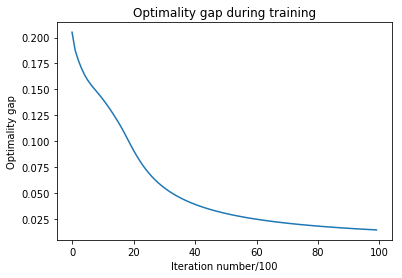

In [24]:
f = plt.figure
plt.plot(np.array(gap))
plt.title('Optimality gap during training')
plt.ylabel('Optimality gap')
plt.xlabel('Iteration number/100')